In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# read and visualize the data

In [160]:
#read the data
df=pd.read_csv("C:\\doc\\OnlineRetail.csv", sep=",", encoding="ISO-8859-1", header=0)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


# Clean the data

In [162]:
#Missing value
# rounding to percentage to get to know the missing value percentage
round(100*(df.isnull().sum())/len(df),2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [163]:
#drop all rwos having missing values
df=df.dropna()
df.shape
df.info
df.describe

<bound method NDFrame.describe of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

             InvoiceDate  UnitPrice  Cust

### Prepare the data for modelling

In [165]:
# R-Recency: number of days since last purchase
#Frequency of transaction
# M-Monetary: Total amount of transcations (revenue contributed)}

In [166]:
#new column : amount
df['amount']=df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [167]:
df['InvoiceNo'].head()

0    536365
1    536365
2    536365
3    536365
4    536365
Name: InvoiceNo, dtype: object

In [168]:
# cust-id  recency  freq  monetary 
grouped_df=df.groupby('CustomerID')['amount'].sum()
grouped_df=grouped_df.reset_index()
grouped_df.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [169]:
frequency= df.groupby('CustomerID')['InvoiceNo'].count()
frequency=frequency.reset_index()
frequency.columns=['CustomerID', 'frequency']

In [170]:
#merge two df
grouped_df=pd.merge(grouped_df,frequency, on='CustomerID', how='inner')

In [171]:
grouped_df.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [172]:
#recency
#cust -3 300 days ago 200,50 ,10, 4
#recency 4
#convert to date time
df['InvoiceDate']= pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')

In [173]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [174]:
max_date=max(df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [175]:
df['diff']=max_date-df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [176]:
#recency
last_purchase=df.groupby('CustomerID')['diff'].min()
last_purchase=last_purchase.reset_index()
last_purchase.head()

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [177]:
grouped_df=pd.merge(grouped_df, last_purchase, on="CustomerID", how="inner")

In [178]:
grouped_df.columns=['CustomerID','amount','frequency','recency']
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [179]:
grouped_df['recency']=grouped_df['recency'].dt.days

In [180]:
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


{'whiskers': [<matplotlib.lines.Line2D at 0x170f50d32c0>,
 'caps': [<matplotlib.lines.Line2D at 0x170f50d3740>,
 'boxes': [<matplotlib.lines.Line2D at 0x170f50d2870>],
 'medians': [<matplotlib.lines.Line2D at 0x170f50d3d70>],
 'fliers': [<matplotlib.lines.Line2D at 0x170f51300e0>],
 'means': []}

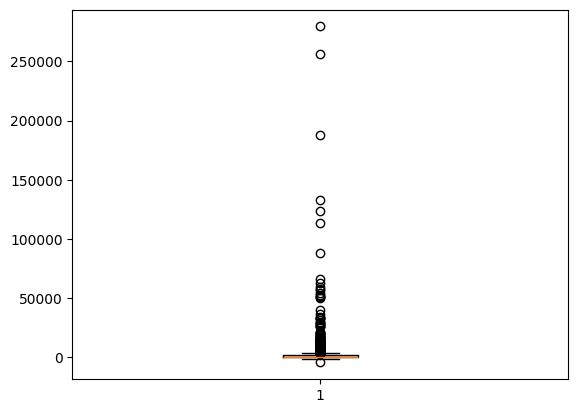

In [181]:
# outlier treatment
plt.boxplot(grouped_df['amount'])

{'whiskers': [<matplotlib.lines.Line2D at 0x170f51cce00>,
 'caps': [<matplotlib.lines.Line2D at 0x170f51cd220>,
 'boxes': [<matplotlib.lines.Line2D at 0x170f51ccb00>],
 'medians': [<matplotlib.lines.Line2D at 0x170f51cd940>],
 'fliers': [<matplotlib.lines.Line2D at 0x170f51cdbe0>],
 'means': []}

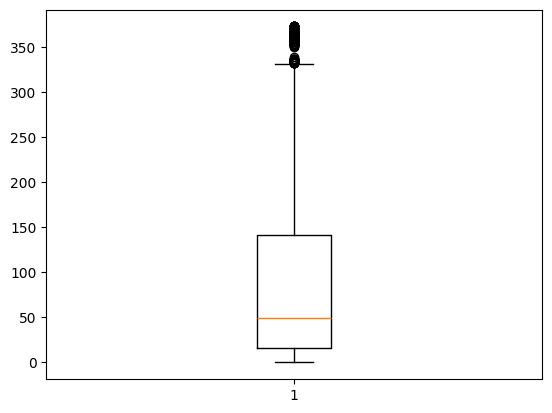

In [182]:
# outlier treatment
plt.boxplot(grouped_df['recency'])

In [183]:
# two types of outliers
# -statistical
# domain

In [184]:
#rescaling
rfm_df=grouped_df[['amount','frequency','recency']]

# instantiate 
scaler=StandardScaler()

# fit transform
rfm_df_scaled=scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4372, 3)

In [185]:
rfm_df_scaled=pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns=['amount','frequency','recency']
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.231001,-0.391720,2.322023
1,0.293432,0.382657,-0.893733
2,-0.012316,-0.266959,-0.169196
3,-0.017146,-0.086271,-0.725005
4,-0.190312,-0.327188,2.163220


In [186]:
# k means from arbitary K
kmeans=KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [187]:
kmeans.labels_

array([1, 0, 0, ..., 0, 0, 0])

### Finding the optimal number of clusters

In [189]:
#elbow-curve/SSD
ssd=[]

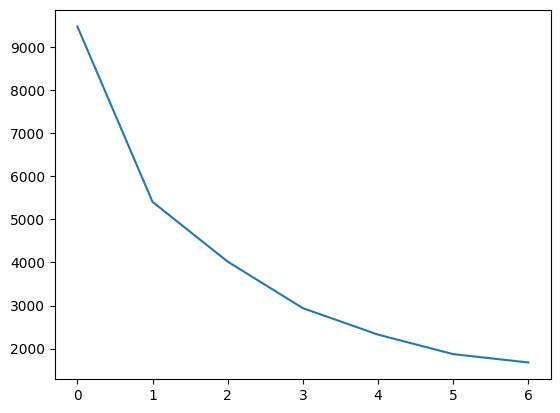

In [190]:
range_n_clusters = [2,3,4,5,6,7,8]
for num_clusters in range_n_clusters : 
    kmeans= KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    ssd.append(kmeans.inertia_)

#plot the SSD for  each cluster
plt.plot(ssd)

In [191]:
#silhoutte analysis
range_n_clusters = [2,3,4,5,6,7,8]
for n_custers in range_n_clusters:
    #initialize kmeans
    kmeans=KMeans(n_clusters = num_clusters , max_iter=50)
    kmeans.fit(rfm_df_scaled)
    cluster_labels=kmeans.labels_

  #silhoutte score
    silhouette_avg= silhouette_score(rfm_df_scaled,cluster_labels)
    print("For n_clusters={0}, silhouette score is {1}".format(num_clusters,silhouette_avg))

For n_clusters=8, silhouette score is 0.5012060818072126
For n_clusters=8, silhouette score is 0.5273323169481515
For n_clusters=8, silhouette score is 0.5231346731737352
For n_clusters=8, silhouette score is 0.5530732341921545
For n_clusters=8, silhouette score is 0.5012060818072126
For n_clusters=8, silhouette score is 0.5282088143177737
For n_clusters=8, silhouette score is 0.3987450844104312


In [192]:
 #final model with k=3
 kmeans=KMeans(n_clusters =3 , max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [193]:
kmeans.labels_

array([0, 2, 2, ..., 2, 2, 2])

In [194]:
# assign the label
grouped_df['cluster_id']=kmeans.labels_
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,2
3,12349.0,1757.55,73,18,2
4,12350.0,334.40,17,309,0


<Axes: xlabel='cluster_id', ylabel='amount'>

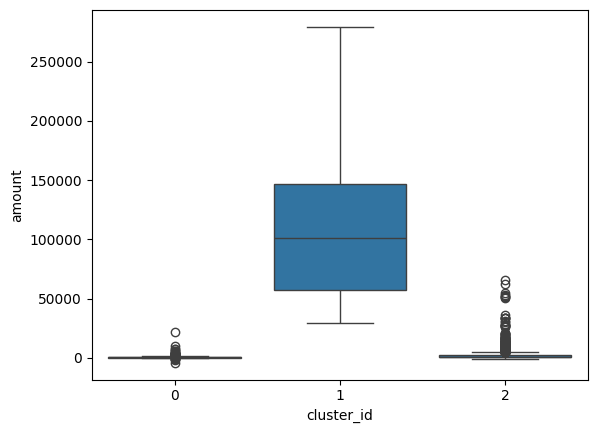

In [195]:
#plot
sns.boxplot(x='cluster_id',y='amount', data=grouped_df)

### Hirerchial Clustering

In [197]:
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.231001,-0.391720,2.322023
1,0.293432,0.382657,-0.893733
2,-0.012316,-0.266959,-0.169196
3,-0.017146,-0.086271,-0.725005
4,-0.190312,-0.327188,2.163220


In [198]:
#grouped_df.head()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


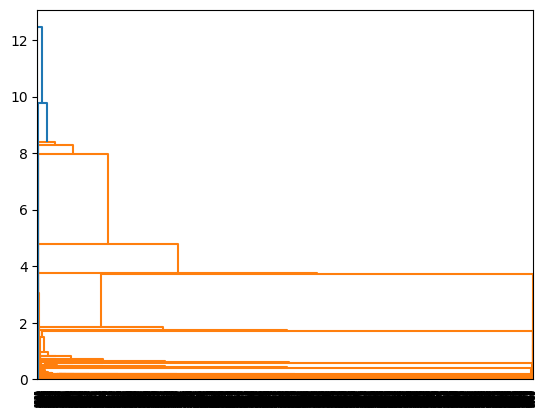

In [199]:
#single linkage
mergings=linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

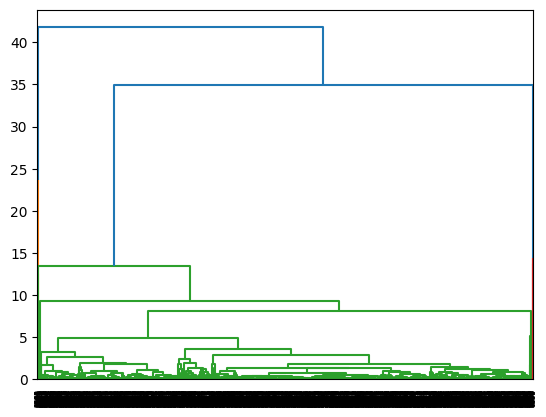

In [200]:
#complete linkage
mergings=linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [201]:
# 3 clusters 
cluster_labels=cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [202]:
# assign cluster labels
grouped_df['cluster_labels']=cluster_labels
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id,cluster_labels
0,12346.0,0.00,2,325,0,0
1,12347.0,4310.00,182,1,2,0
2,12348.0,1797.24,31,74,2,0
3,12349.0,1757.55,73,18,2,0
4,12350.0,334.40,17,309,0,0


<Axes: xlabel='cluster_labels', ylabel='amount'>

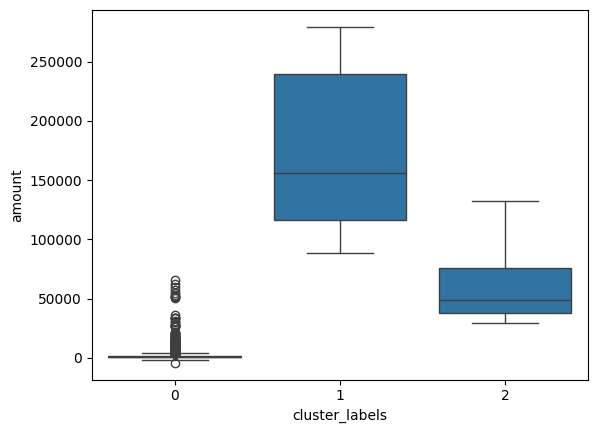

In [203]:
#plots

sns.boxplot(x='cluster_labels', y='amount', data=grouped_df)